In [110]:
!pip install torch-geometric

StatementMeta(team14elliptic, 19, 3, Finished, Available, Finished)

In [167]:
# 1. Setup and Configuration
# --------------------------
# Configure storage account access
storage_account_name = "team14storage"
storage_account_key = "BqTUGm0vEddQ0O5wOaAzGNjFqZVnK4ZnhfvBYjBhfLbcBPoeO43ABkRBPhdgzwuyzoYDInfw0wjs+ASt89HrGw=="

spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.dfs.core.windows.net",
    storage_account_key
)

StatementMeta(team14elliptic, 19, 60, Finished, Available, Finished)

In [168]:
# Import required libraries
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.window import Window
import seaborn as sns
from pyspark.ml.clustering import KMeans

StatementMeta(team14elliptic, 19, 61, Finished, Available, Finished)

In [183]:
# 2. Data Loading
# ---------------
# Read each CSV into its own DataFrame
elliptic_txs_classes_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_classes.csv"
        )
)

elliptic_txs_edgelist_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_edgelist.csv"
        )
)

elliptic_txs_features_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_features.csv"
        )
)

StatementMeta(team14elliptic, 19, 76, Finished, Available, Finished)

In [184]:
# 3. Initial Data Exploration
# ---------------------------
# First, rename the columns in the features dataframe
# We assume the first column is 'txId' and the second is 'time_step'
feature_columns = elliptic_txs_features_df.columns
new_columns = ['txId', 'time_step'] 
for i in range(2, len(feature_columns)):
    new_columns.append(f'feature_{i-1}')

elliptic_txs_features_df = elliptic_txs_features_df.toDF(*new_columns)

print("Dataset Overview:")
print(f"Classes DataFrame: {elliptic_txs_classes_df.count()} rows")
print(f"Edgelist DataFrame: {elliptic_txs_edgelist_df.count()} rows")
print(f"Features DataFrame: {elliptic_txs_features_df.count()} rows")

print("\nClasses DataFrame Schema:")
elliptic_txs_classes_df.printSchema()

print("\nEdgelist DataFrame Schema:")
elliptic_txs_edgelist_df.printSchema()

print("\nFeatures DataFrame Schema:")
elliptic_txs_features_df.printSchema()

# Sample data display
print("\nSample rows from Classes DataFrame:")
display(elliptic_txs_classes_df.limit(5))

print("\nSample rows from Edgelist DataFrame:")
display(elliptic_txs_edgelist_df.limit(5))

print("\nSample rows from Features DataFrame:")
display(elliptic_txs_features_df.limit(5))

StatementMeta(team14elliptic, 19, 77, Finished, Available, Finished)

Dataset Overview:
Classes DataFrame: 203769 rows
Edgelist DataFrame: 234355 rows
Features DataFrame: 24789 rows

Classes DataFrame Schema:
root
 |-- txId: integer (nullable = true)
 |-- class: string (nullable = true)


Edgelist DataFrame Schema:
root
 |-- txId1: integer (nullable = true)
 |-- txId2: integer (nullable = true)


Features DataFrame Schema:
root
 |-- txId: integer (nullable = true)
 |-- time_step: integer (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable = true)
 |-- feature_5: double (nullable = true)
 |-- feature_6: double (nullable = true)
 |-- feature_7: double (nullable = true)
 |-- feature_8: double (nullable = true)
 |-- feature_9: double (nullable = true)
 |-- feature_10: double (nullable = true)
 |-- feature_11: double (nullable = true)
 |-- feature_12: double (nullable = true)
 |-- feature_13: double (nullable = true)
 |-- feature_14: doubl

SynapseWidget(Synapse.DataFrame, a07de8bf-bed8-40e6-89a8-c59af6b7d586)


Sample rows from Edgelist DataFrame:


SynapseWidget(Synapse.DataFrame, 297ea8c8-7c11-42e1-a1fc-cc6e6eb1e784)


Sample rows from Features DataFrame:


SynapseWidget(Synapse.DataFrame, a90e2f61-c5ed-43d5-81f2-6efacc763a86)

In [185]:
# 4. Data Cleaning and Preprocessing
# ---------------------------------
# Check for missing values
def check_null_values(df, df_name):
    print(f"\nChecking null values in {df_name}:")
    null_counts = []
    for col in df.columns:
        null_count = df.filter(df[col].isNull()).count()
        if null_count > 0:
            null_counts.append((col, null_count))
    
    if null_counts:
        for col, count in null_counts:
            print(f"Column '{col}' has {count} null values")
    else:
        print("No null values found")

check_null_values(elliptic_txs_classes_df, "Classes DataFrame")
check_null_values(elliptic_txs_edgelist_df, "Edgelist DataFrame")
check_null_values(elliptic_txs_features_df, "Features DataFrame")

# Since we already renamed the columns in the initial exploration step, we can skip this

# Convert class labels to binary for supervised learning
# 'unknown' will be excluded from training data
elliptic_txs_classes_df = elliptic_txs_classes_df.withColumn(
    "class",
    F.when(F.col("class") == "1", 1).when(F.col("class") == "2", 0).otherwise(None)
)

StatementMeta(team14elliptic, 19, 78, Finished, Available, Finished)


Checking null values in Classes DataFrame:
No null values found

Checking null values in Edgelist DataFrame:
No null values found

Checking null values in Features DataFrame:
Column 'feature_131' has 1 null values
Column 'feature_132' has 1 null values
Column 'feature_133' has 1 null values
Column 'feature_134' has 1 null values
Column 'feature_135' has 1 null values
Column 'feature_136' has 1 null values
Column 'feature_137' has 1 null values
Column 'feature_138' has 1 null values
Column 'feature_139' has 1 null values
Column 'feature_140' has 1 null values
Column 'feature_141' has 1 null values
Column 'feature_142' has 1 null values
Column 'feature_143' has 1 null values
Column 'feature_144' has 1 null values
Column 'feature_145' has 1 null values
Column 'feature_146' has 1 null values
Column 'feature_147' has 1 null values
Column 'feature_148' has 1 null values
Column 'feature_149' has 1 null values
Column 'feature_150' has 1 null values
Column 'feature_151' has 1 null values
Colum

In [186]:
# 5. Join the DataFrames to create a combined dataset
# --------------------------------------------------
# Join classes and features
combined_df = elliptic_txs_features_df.join(
    elliptic_txs_classes_df,
    elliptic_txs_features_df.txId == elliptic_txs_classes_df.txId,
    "left"
).drop(elliptic_txs_classes_df.txId)

# Print the shape of the combined DataFrame
print("\nCombined DataFrame shape:")
print(f"Rows: {combined_df.count()}, Columns: {len(combined_df.columns)}")

# Display class distribution
class_distribution = combined_df.groupBy("class").count().orderBy("class")
print("\nClass distribution:")
display(class_distribution)

# Convert to a pandas DataFrame for visualization
class_dist_pd = class_distribution.toPandas()
class_labels = ['Illicit (1)', 'Licit (0)', 'Unknown (None)']
class_dist_pd['class_label'] = class_labels

StatementMeta(team14elliptic, 19, 79, Finished, Available, Finished)


Combined DataFrame shape:
Rows: 24789, Columns: 168

Class distribution:


SynapseWidget(Synapse.DataFrame, e787b7d5-3455-4dc1-a0c7-cf7db8374fcc)

StatementMeta(team14elliptic, 19, 80, Finished, Available, Finished)


Feature Statistics:


SynapseWidget(Synapse.DataFrame, aa312135-c528-4bc5-943b-a5850efc2932)

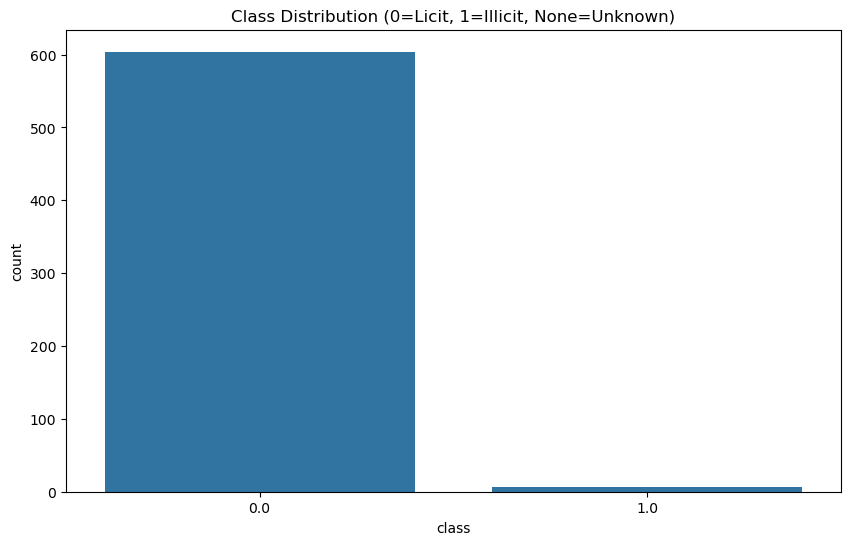

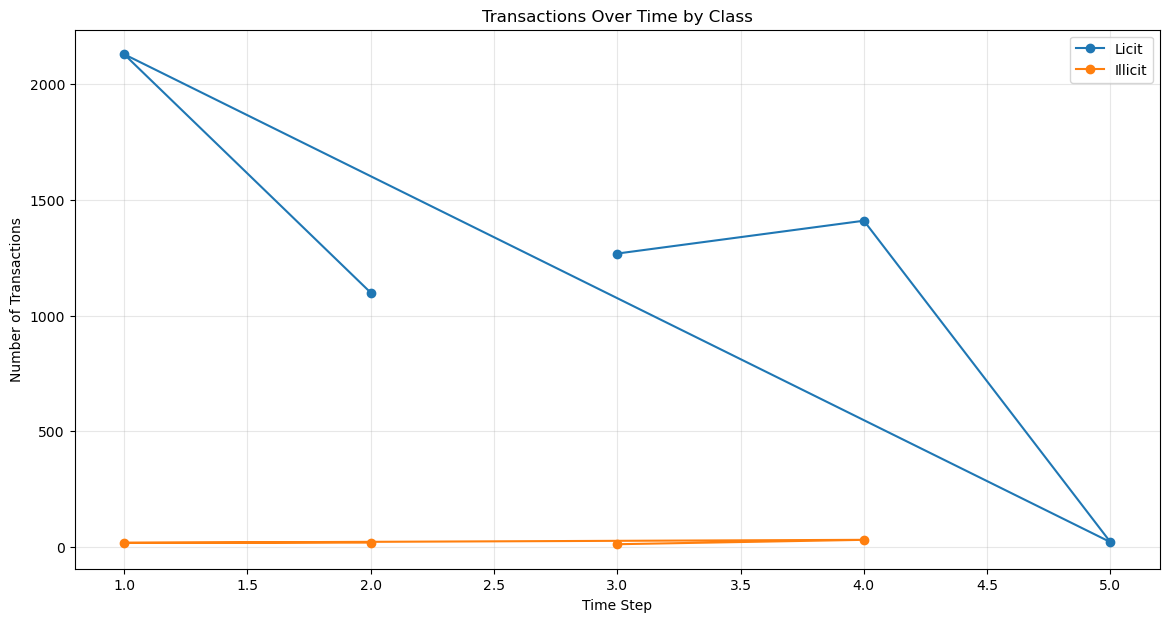

In [187]:
# 6. Statistical Analysis and Visualization
# ----------------------------------------
# Basic statistics for numeric features
numeric_features = [col for col in combined_df.columns 
                    if col not in ['txId', 'class', 'time_step'] 
                    and combined_df.schema[col].dataType in [IntegerType(), DoubleType(), FloatType()]]

print("\nFeature Statistics:")
stats_df = combined_df.select(numeric_features).summary()
display(stats_df)

# Convert to pandas for easier plotting
# Limiting to a smaller sample for visualization purposes
pd_df = combined_df.sample(False, 0.1, seed=42).toPandas()

# Create a plot to show class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=pd_df)
plt.title('Class Distribution (0=Licit, 1=Illicit, None=Unknown)')
plt.savefig('/tmp/class_distribution.png')
display(plt.gcf())
plt.close()

# Create a plot to show transactions over time
time_class_counts = combined_df.groupBy("time_step", "class").count()
time_class_counts_pd = time_class_counts.toPandas()

plt.figure(figsize=(14, 7))
for class_val in [0, 1]:
    subset = time_class_counts_pd[time_class_counts_pd['class'] == class_val]
    if not subset.empty:
        plt.plot(subset['time_step'], subset['count'], 
                 marker='o', linestyle='-', 
                 label=f"{'Illicit' if class_val == 1 else 'Licit'}")

plt.title('Transactions Over Time by Class')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/tmp/transactions_over_time.png')
display(plt.gcf())
plt.close()

In [188]:
# 7. Feature Engineering
# ----------------------
# Create local clustering coefficient for each node using the edgelist
# First, let's calculate the degree of each node
node_degrees = (
    elliptic_txs_edgelist_df.select("txId1")
    .union(elliptic_txs_edgelist_df.select("txId2"))
    .groupBy("txId1")
    .count()
    .withColumnRenamed("txId1", "txId")
    .withColumnRenamed("count", "degree")
)

# Add degree information to the combined dataset
combined_df = combined_df.join(node_degrees, on="txId", how="left").fillna(0, subset=["degree"])

# Calculate additional graph-based features
# For each node, calculate:
# 1. In-degree (number of incoming transactions)
# 2. Out-degree (number of outgoing transactions)

in_degree = (
    elliptic_txs_edgelist_df.groupBy("txId2")
    .count()
    .withColumnRenamed("txId2", "txId")
    .withColumnRenamed("count", "in_degree")
)

out_degree = (
    elliptic_txs_edgelist_df.groupBy("txId1")
    .count()
    .withColumnRenamed("txId1", "txId")
    .withColumnRenamed("count", "out_degree")
)

# Add in-degree and out-degree to combined dataset
combined_df = combined_df.join(in_degree, on="txId", how="left").fillna(0, subset=["in_degree"])
combined_df = combined_df.join(out_degree, on="txId", how="left").fillna(0, subset=["out_degree"])

# Create feature for the ratio of in_degree to out_degree (with handling for division by zero)
combined_df = combined_df.withColumn(
    "in_out_ratio",
    F.when(F.col("out_degree") > 0, F.col("in_degree") / F.col("out_degree")).otherwise(0)
)

# Feature: Calculate time-step based features
# For each transaction, calculate the time difference from the first transaction
combined_df = combined_df.withColumn(
    "time_since_start",
    F.col("time_step") - 1
)

# Feature: Create aggregated features by time_step
time_agg = (
    combined_df.groupBy("time_step")
    .agg(
        F.count("*").alias("total_tx_in_timestep"),
        F.avg("degree").alias("avg_degree_in_timestep"),
        F.avg("in_degree").alias("avg_in_degree_in_timestep"),
        F.avg("out_degree").alias("avg_out_degree_in_timestep")
    )
)

# Join the time-based aggregated features
combined_df = combined_df.join(time_agg, on="time_step")

# Create a feature to indicate if a transaction has unusual degree compared to others in its timestep
# Calculate the Z-score for degree within each timestep
window_spec = Window.partitionBy("time_step")

combined_df = combined_df.withColumn(
    "degree_avg_in_timestep", F.avg("degree").over(window_spec)
)
combined_df = combined_df.withColumn(
    "degree_stddev_in_timestep", F.stddev("degree").over(window_spec)
)
combined_df = combined_df.withColumn(
    "degree_zscore",
    F.when(
        F.col("degree_stddev_in_timestep") > 0,
        (F.col("degree") - F.col("degree_avg_in_timestep")) / F.col("degree_stddev_in_timestep")
    ).otherwise(0)
)

StatementMeta(team14elliptic, 19, 81, Finished, Available, Finished)

In [200]:
#  8. Prepare data for Machine Learning
# -----------------------------------
# Filter out transactions with unknown class
# Filter out transactions with unknown class 
# (where class is not null)
labeled_df = combined_df.filter("class IS NOT NULL")

# Split the data into features and label
feature_cols = [col for col in combined_df.columns 
                if col not in ['txId', 'class'] 
                and combined_df.schema[col].dataType in [IntegerType(), DoubleType(), FloatType()]]

# Create a pipeline for preprocessing
vector_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_unscaled"
)

scaler = StandardScaler(
    inputCol="features_unscaled",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Split data into training and testing sets
train_df, test_df = labeled_df.randomSplit([0.8, 0.2], seed=42)

StatementMeta(team14elliptic, 19, 93, Finished, Available, Finished)

In [190]:
# 9. Implement Machine Learning Models
# -----------------------------------
# A. Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="class",
    maxIter=10,
    regParam=0.3
)

lr_pipeline = Pipeline(stages=[vector_assembler, scaler, lr])
lr_model = lr_pipeline.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Evaluate Logistic Regression model
lr_evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction",
    labelCol="class",
    metricName="areaUnderROC"
)
lr_auc = lr_evaluator.evaluate(lr_predictions)
print(f"\nLogistic Regression - AUC: {lr_auc:.4f}")

# B. Random Forest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="class",
    numTrees=10
)

rf_pipeline = Pipeline(stages=[vector_assembler, scaler, rf])
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate Random Forest model
rf_auc = lr_evaluator.evaluate(rf_predictions)
print(f"Random Forest - AUC: {rf_auc:.4f}")

# C. Support Vector Machine (SVM)
svm = LinearSVC(
    featuresCol="features",
    labelCol="class",
    maxIter=10,
    regParam=0.1
)

svm_pipeline = Pipeline(stages=[vector_assembler, scaler, svm])
svm_model = svm_pipeline.fit(train_df)
svm_predictions = svm_model.transform(test_df)

# Evaluate SVM model
svm_evaluator = MulticlassClassificationEvaluator(
    labelCol="class",
    predictionCol="prediction",
    metricName="accuracy"
)
svm_accuracy = svm_evaluator.evaluate(svm_predictions)
print(f"SVM - Accuracy: {svm_accuracy:.4f}")

# D. Gradient Boosted Trees
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="class",
    maxIter=10
)

gbt_pipeline = Pipeline(stages=[vector_assembler, scaler, gbt])
gbt_model = gbt_pipeline.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

# Evaluate GBT model
gbt_auc = lr_evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees - AUC: {gbt_auc:.4f}")

StatementMeta(team14elliptic, 19, 83, Finished, Available, Finished)


Logistic Regression - AUC: 0.8537
Random Forest - AUC: 0.9494
SVM - Accuracy: 0.9852
Gradient Boosted Trees - AUC: 0.9515


StatementMeta(team14elliptic, 19, 95, Finished, Available, Finished)

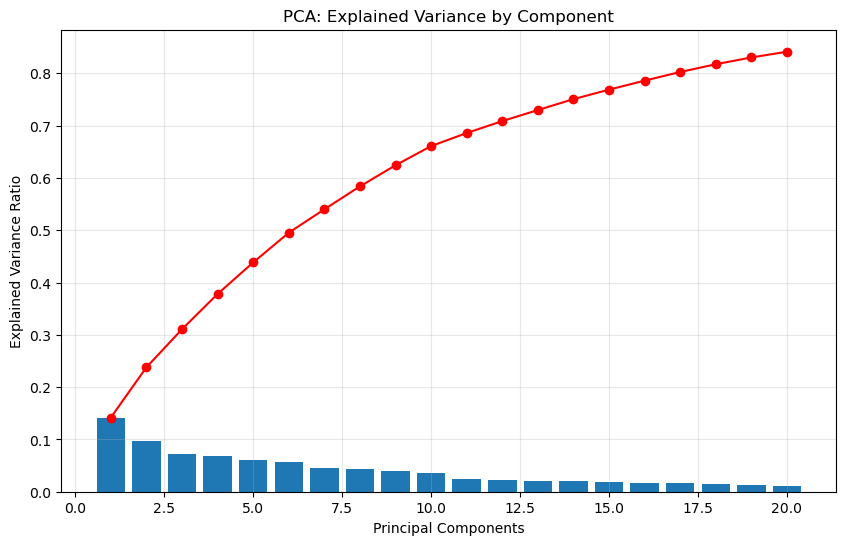

In [202]:
# 10. Unsupervised Learning - Autoencoder using PCA
# ------------------------------------------------
# Use PCA to reduce dimensionality and detect anomalies
num_principal_components = 20
pca = PCA(
    k=num_principal_components,
    inputCol="features_unscaled",
    outputCol="pca_features"
)

pca_pipeline = Pipeline(stages=[vector_assembler, scaler, pca])
pca_model = pca_pipeline.fit(train_df)
pca_results = pca_model.transform(combined_df)

# Display explained variance
explained_variance = pca_model.stages[-1].explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance by Component')
plt.grid(True, alpha=0.3)
plt.savefig('/tmp/pca_explained_variance.png')
display(plt.gcf())
plt.close()

StatementMeta(team14elliptic, 19, 86, Finished, Available, Finished)

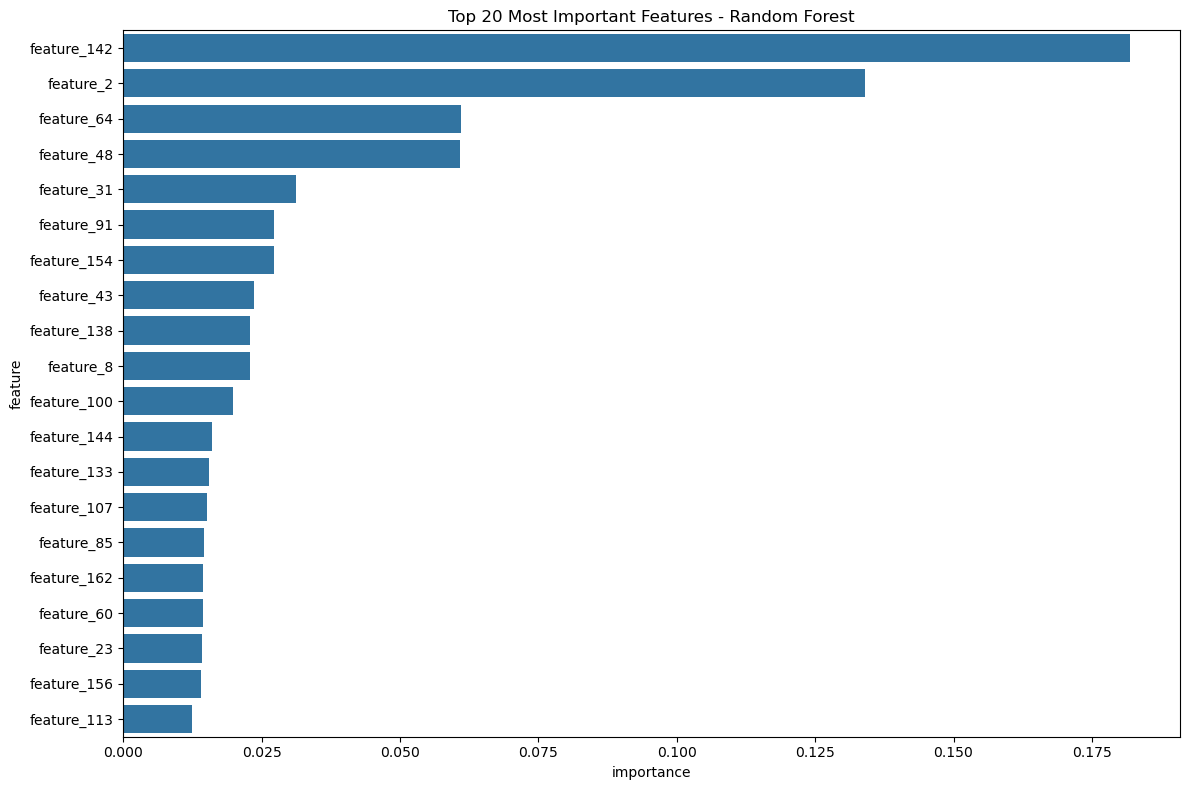

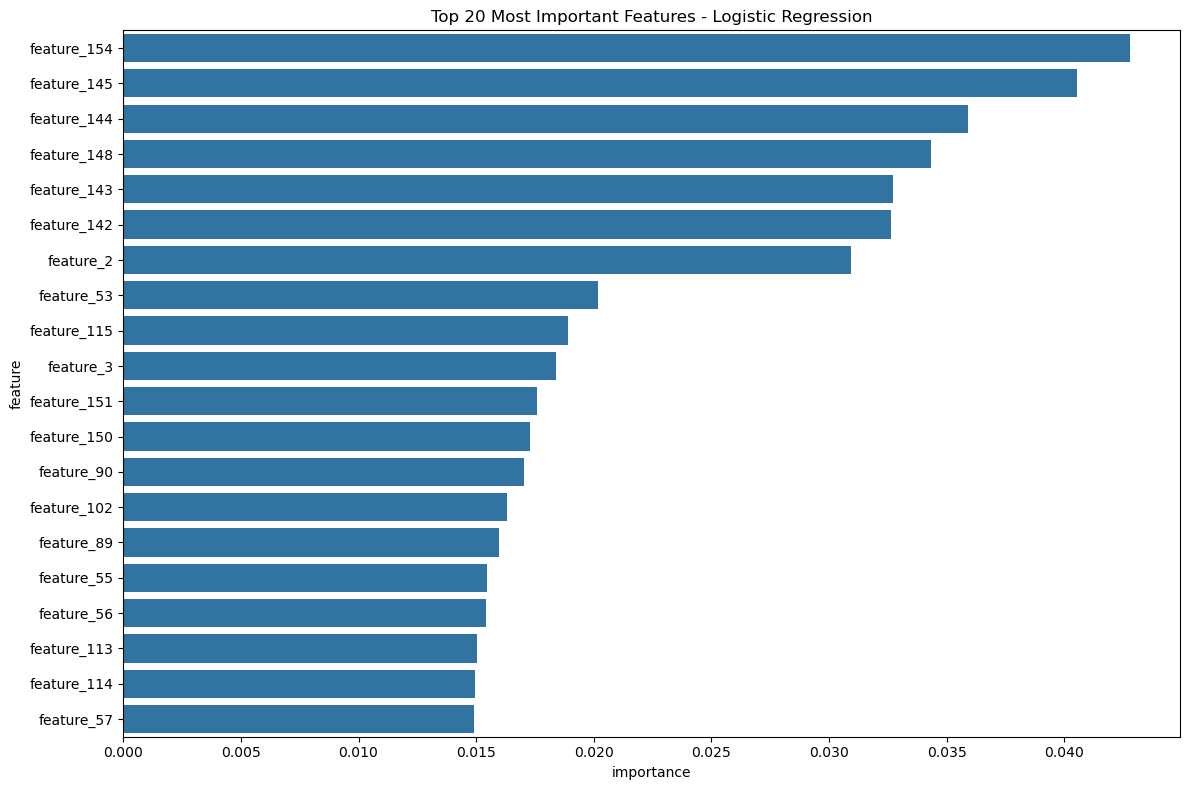

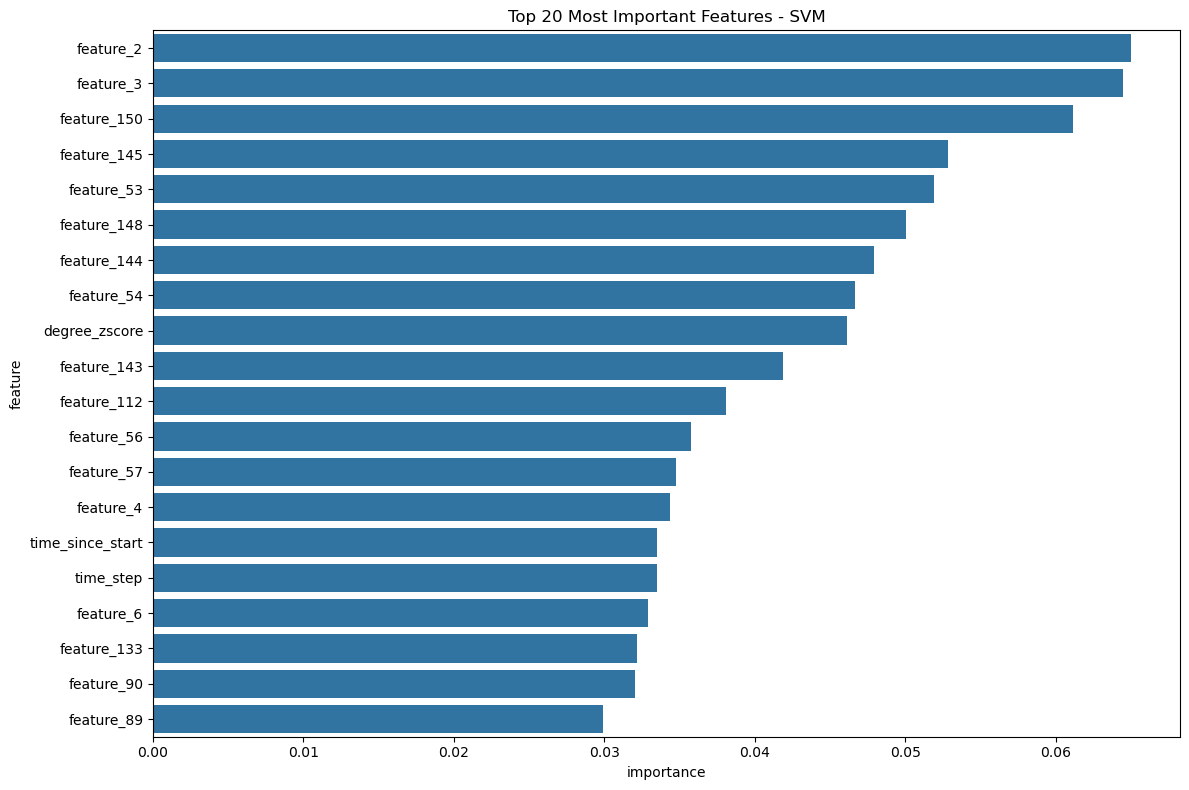

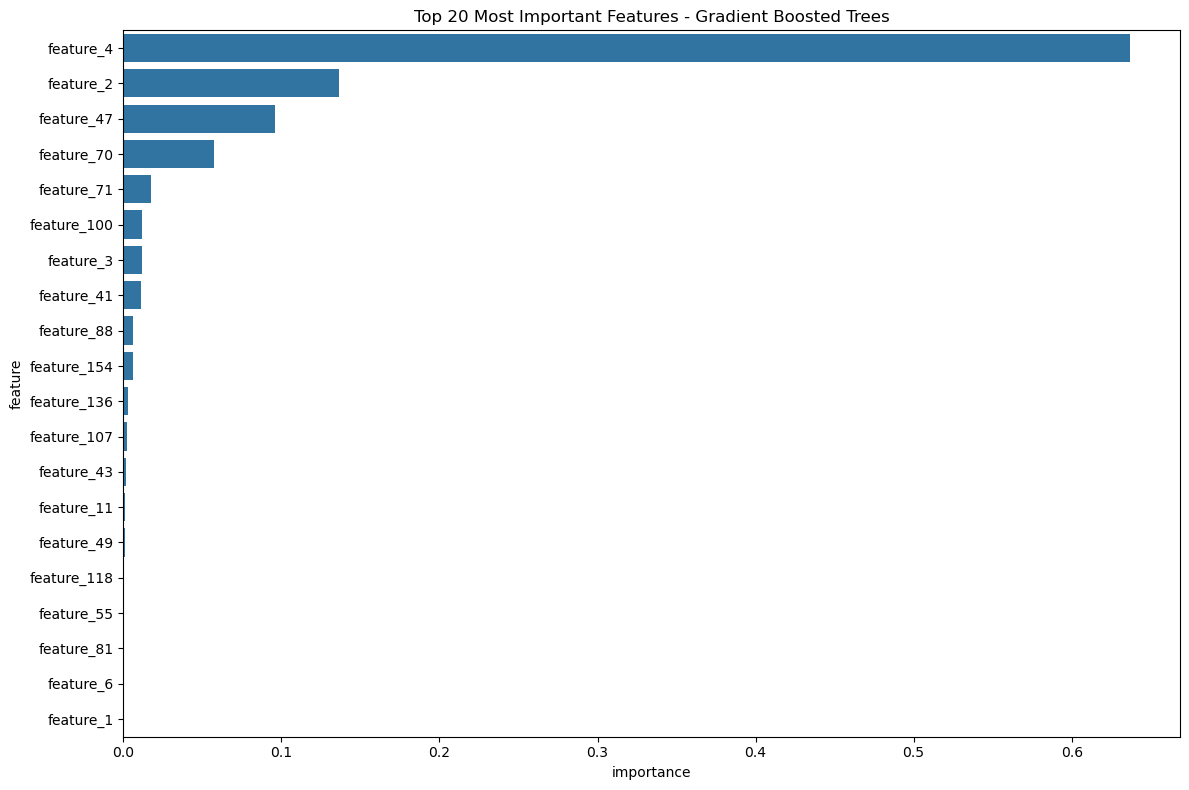

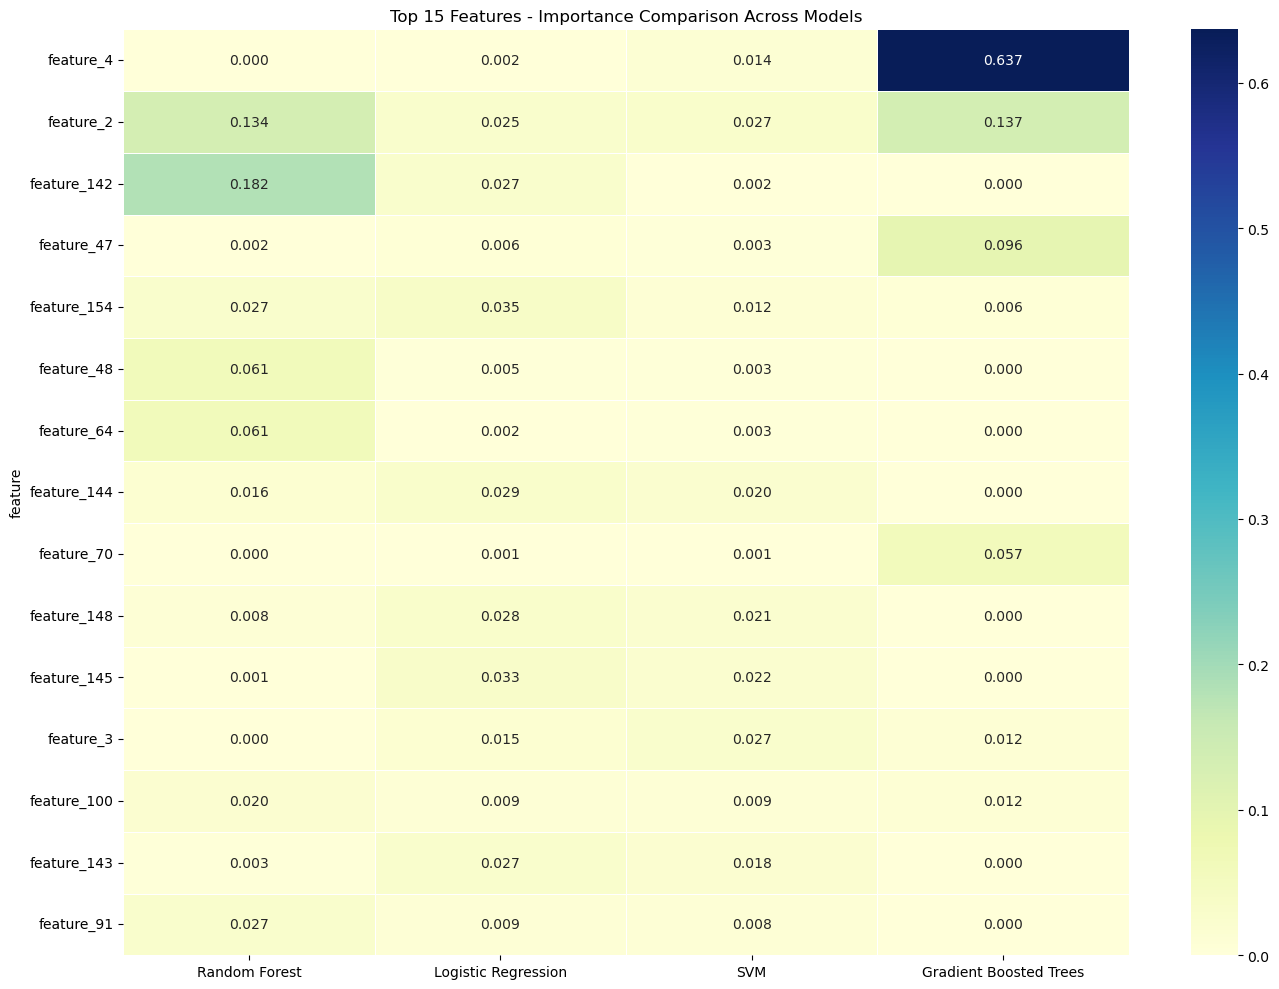

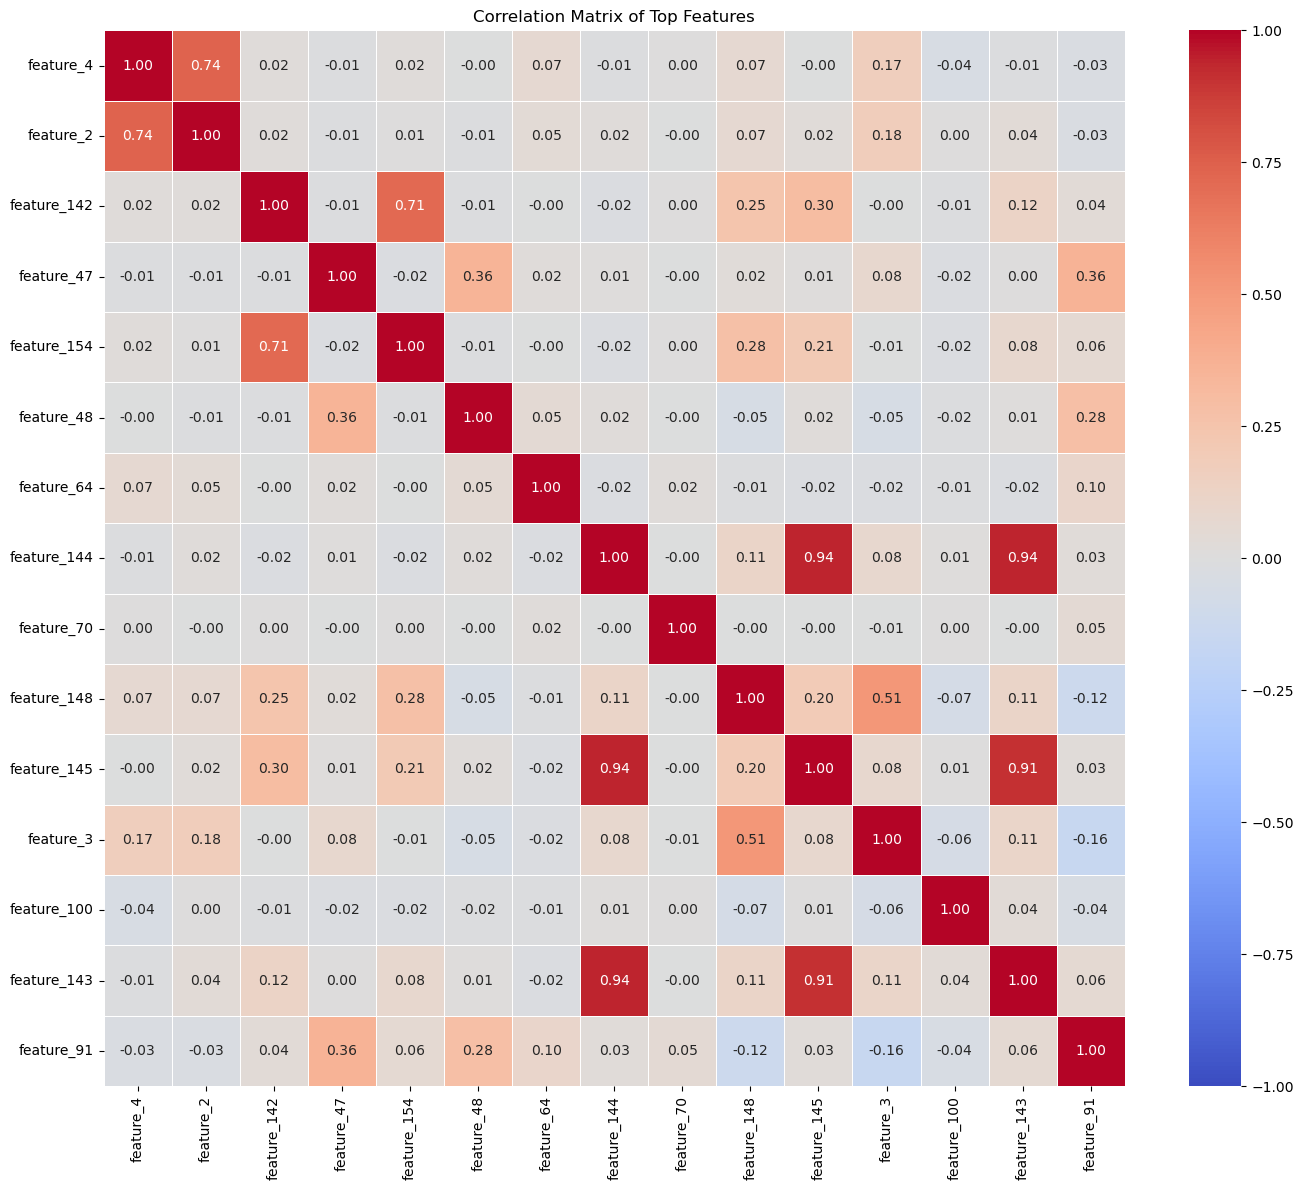

In [193]:
# 11. Feature Importance Analysis for All Models
# -------------------------------------------
# Compare feature importances across all models

# 1. Random Forest Feature Importance
rf_feature_importance = pd.DataFrame(
    list(zip(feature_cols, rf_model.stages[-1].featureImportances.toArray())),
    columns=["feature", "importance"]
).sort_values("importance", ascending=False)

# Plot top 20 most important features for Random Forest
top_rf_features = rf_feature_importance.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=top_rf_features)
plt.title('Top 20 Most Important Features - Random Forest')
plt.tight_layout()
plt.savefig('/tmp/rf_feature_importance.png')
display(plt.gcf())
plt.close()

# 2. Logistic Regression Coefficient Analysis
# For logistic regression, the coefficients can be used as feature importance
lr_coefficients = lr_model.stages[-1].coefficients.toArray()
lr_feature_importance = pd.DataFrame(
    list(zip(feature_cols, np.abs(lr_coefficients))),  # Use absolute values for importance
    columns=["feature", "importance"]
).sort_values("importance", ascending=False)

# Plot top 20 most important features for Logistic Regression
top_lr_features = lr_feature_importance.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=top_lr_features)
plt.title('Top 20 Most Important Features - Logistic Regression')
plt.tight_layout()
plt.savefig('/tmp/lr_feature_importance.png')
display(plt.gcf())
plt.close()

# 3. SVM Coefficient Analysis
svm_coefficients = svm_model.stages[-1].coefficients.toArray()
svm_feature_importance = pd.DataFrame(
    list(zip(feature_cols, np.abs(svm_coefficients))),  # Use absolute values for importance
    columns=["feature", "importance"]
).sort_values("importance", ascending=False)

# Plot top 20 most important features for SVM
top_svm_features = svm_feature_importance.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=top_svm_features)
plt.title('Top 20 Most Important Features - SVM')
plt.tight_layout()
plt.savefig('/tmp/svm_feature_importance.png')
display(plt.gcf())
plt.close()

# 4. GBT Feature Importance
# For GBT Classifier, feature importances are available like Random Forest
gbt_feature_importance = pd.DataFrame(
    list(zip(feature_cols, gbt_model.stages[-1].featureImportances.toArray())),
    columns=["feature", "importance"]
).sort_values("importance", ascending=False)

# Plot top 20 most important features for GBT
top_gbt_features = gbt_feature_importance.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=top_gbt_features)
plt.title('Top 20 Most Important Features - Gradient Boosted Trees')
plt.tight_layout()
plt.savefig('/tmp/gbt_feature_importance.png')
display(plt.gcf())
plt.close()

# 5. Create a consolidated feature importance visualization
# Find the top 15 features across all models
top_features_all_models = pd.DataFrame({
    "Random Forest": rf_feature_importance.set_index("feature")["importance"],
    "Logistic Regression": lr_feature_importance.set_index("feature")["importance"],
    "SVM": svm_feature_importance.set_index("feature")["importance"],
    "Gradient Boosted Trees": gbt_feature_importance.set_index("feature")["importance"]
})

# Normalize importance values to make them comparable across models
for column in top_features_all_models.columns:
    top_features_all_models[column] = top_features_all_models[column] / top_features_all_models[column].sum()

# Get the top 15 features based on average importance across all models
top_features_all_models["Average"] = top_features_all_models.mean(axis=1)
top_15_features = top_features_all_models.sort_values("Average", ascending=False).head(15)

# Create a heatmap to compare feature importance across models
plt.figure(figsize=(14, 10))
sns.heatmap(
    top_15_features.drop("Average", axis=1), 
    annot=True, 
    cmap="YlGnBu", 
    fmt=".3f",
    linewidths=.5
)
plt.title('Top 15 Features - Importance Comparison Across Models')
plt.tight_layout()
plt.savefig('/tmp/feature_importance_comparison.png')
display(plt.gcf())
plt.close()

# 6. Feature Correlation Analysis
# Calculate correlation matrix for features
numeric_feature_cols = [col for col in feature_cols if combined_df.schema[col].dataType in [IntegerType(), DoubleType(), FloatType()]]
feature_correlation = combined_df.select(numeric_feature_cols).toPandas().corr()

# Plot correlation heatmap for top features
top_correlated_features = top_15_features.index.tolist()
# Filter only features that exist in our correlation matrix
top_correlated_features = [f for f in top_correlated_features if f in feature_correlation.columns]
plt.figure(figsize=(14, 12))
sns.heatmap(
    feature_correlation.loc[top_correlated_features, top_correlated_features],
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.savefig('/tmp/feature_correlation.png')
display(plt.gcf())
plt.close()

# 7. Save feature importance results for PowerBI visualization
# Combine all feature importance dataframes with model name
rf_feature_importance["model"] = "Random Forest"
lr_feature_importance["model"] = "Logistic Regression"
svm_feature_importance["model"] = "SVM"
gbt_feature_importance["model"] = "Gradient Boosted Trees"

# Concatenate all feature importance dataframes
all_feature_importance = pd.concat([
    rf_feature_importance, lr_feature_importance, svm_feature_importance, gbt_feature_importance
])

# Convert back to Spark DataFrame
all_feature_importance_spark = spark.createDataFrame(all_feature_importance)

StatementMeta(team14elliptic, 19, 88, Finished, Available, Finished)

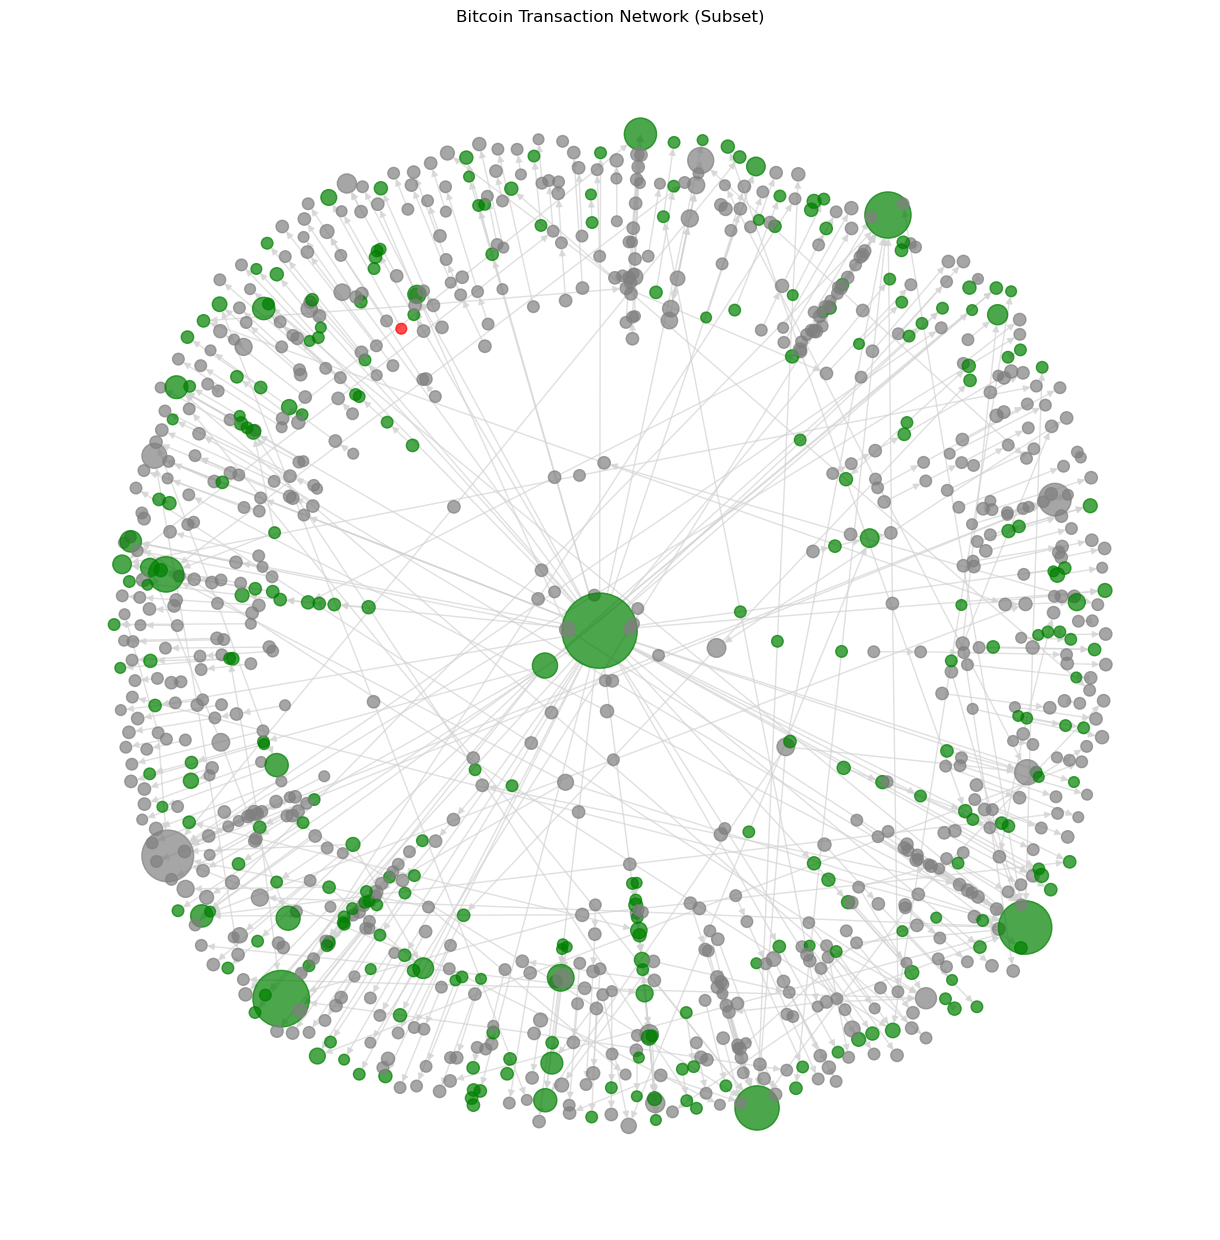

In [195]:
# 14. Graph Visualization (Node-Edge Diagram)
# -----------------------------------------
# Prepare a subset of the graph for visualization
# (using a smaller subset for visualization purposes)
subset_size = 1000
subset_nodes = combined_df.limit(subset_size).select("txId").collect()
subset_node_ids = [row["txId"] for row in subset_nodes]

# Filter edgelist to only include edges between nodes in our subset
subset_edges = elliptic_txs_edgelist_df.filter(
    (F.col("txId1").isin(subset_node_ids)) & 
    (F.col("txId2").isin(subset_node_ids))
)

# Convert to pandas for visualization
subset_edges_pd = subset_edges.toPandas()
subset_nodes_pd = combined_df.filter(F.col("txId").isin(subset_node_ids)).select(
    "txId", "class", "time_step", "degree", "in_degree", "out_degree"
).toPandas()

# Create a networkx graph for visualization
import networkx as nx

G = nx.DiGraph()

# Add nodes with attributes
for _, row in subset_nodes_pd.iterrows():
    G.add_node(
        row["txId"], 
        class_label=row["class"],
        time_step=row["time_step"],
        degree=row["degree"]
    )

# Add edges
for _, row in subset_edges_pd.iterrows():
    G.add_edge(row["txId1"], row["txId2"])

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

# Color nodes by class
node_colors = []
for node in G.nodes():
    node_class = G.nodes[node]["class_label"]
    if node_class == 1:  # Illicit
        node_colors.append("red")
    elif node_class == 0:  # Licit
        node_colors.append("green")
    else:  # Unknown
        node_colors.append("gray")

# Size nodes by degree
node_sizes = [G.nodes[node]["degree"] * 10 + 50 for node in G.nodes()]

nx.draw(
    G, 
    pos, 
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=False,
    arrows=True,
    alpha=0.7,
    edge_color="lightgray"
)

plt.title("Bitcoin Transaction Network (Subset)")
plt.savefig('/tmp/transaction_network.png')
display(plt.gcf())
plt.close()

StatementMeta(team14elliptic, 19, 103, Finished, Available, Finished)


Model Comparison:


SynapseWidget(Synapse.DataFrame, 5cd2f0d0-ba83-4638-ab02-3cb8f8eb5b0f)

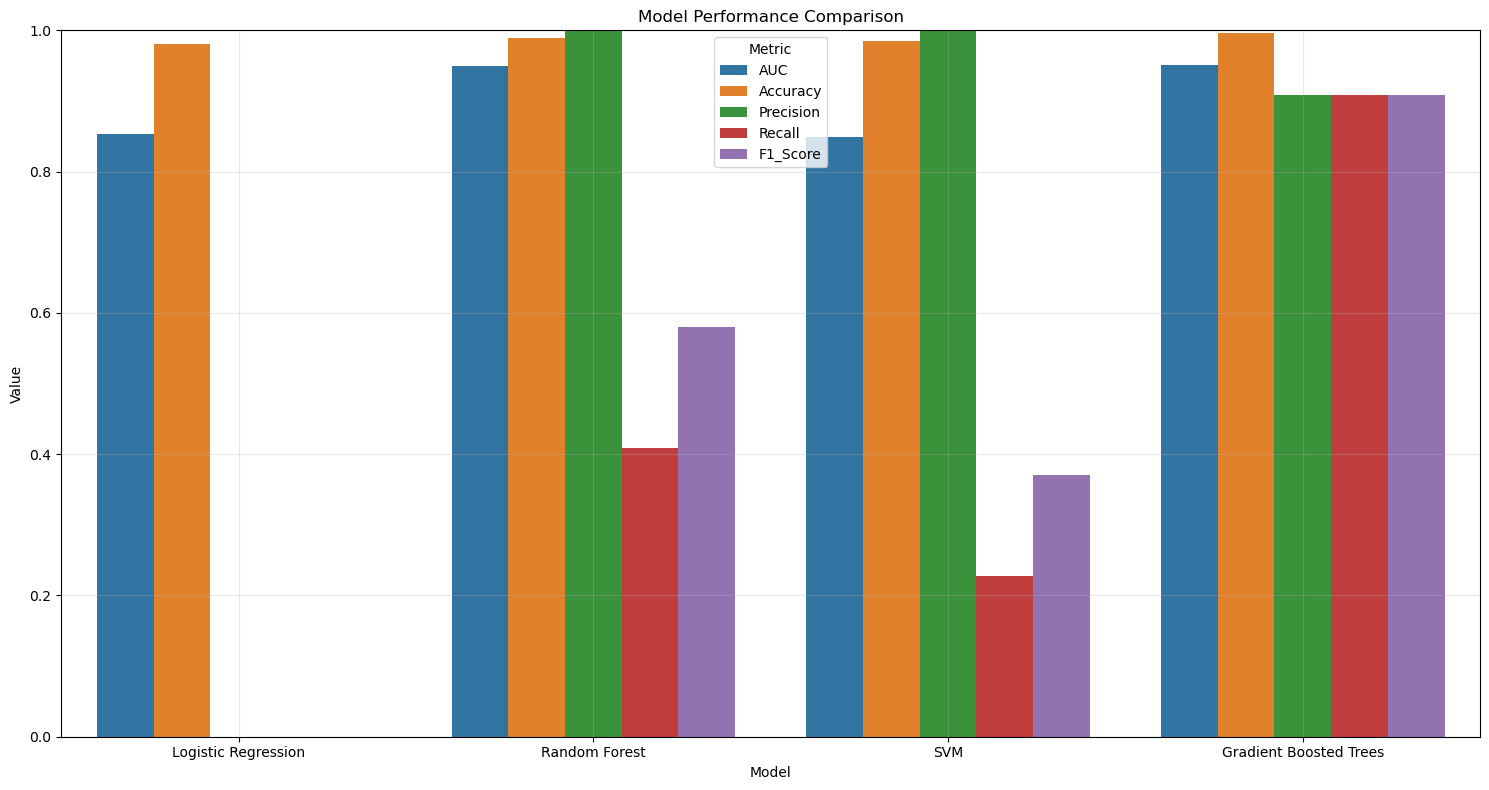

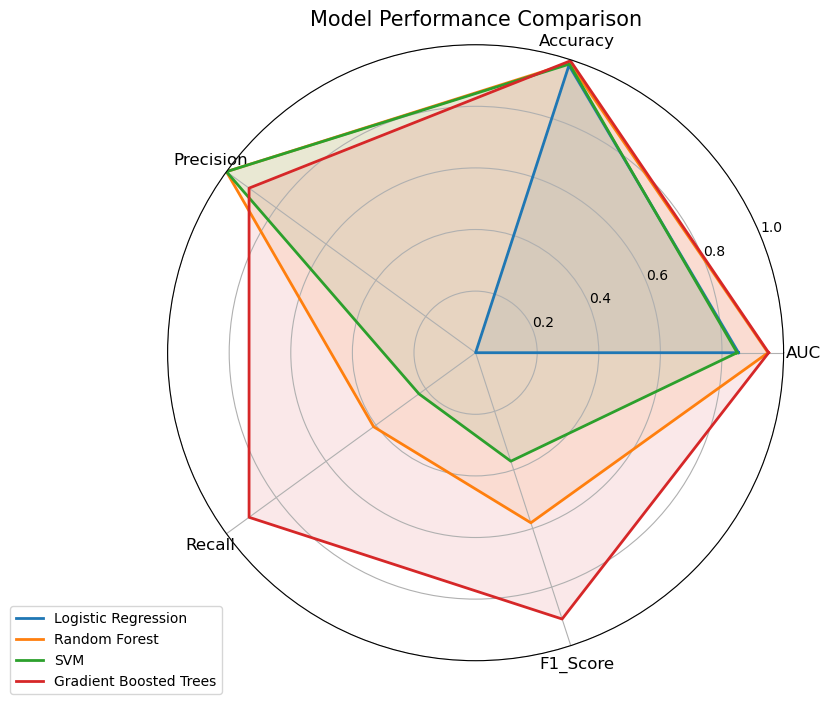

In [210]:
# 15. Model Evaluation and Comparison
# ---------------------------------
# Create a function to evaluate all models
def evaluate_model(predictions, model_name):
    # Calculate metrics
    evaluator = BinaryClassificationEvaluator(labelCol="class")
    auc = evaluator.evaluate(predictions)
    
    # Calculate accuracy
    accuracy = predictions.filter(
        (F.col("prediction") == F.col("class"))
    ).count() / predictions.count()
    
    # Calculate precision, recall, and F1 score for each class
    tp = predictions.filter(
        (F.col("prediction") == 1) & (F.col("class") == 1)
    ).count()
    fp = predictions.filter(
        (F.col("prediction") == 1) & (F.col("class") == 0)
    ).count()
    fn = predictions.filter(
        (F.col("prediction") == 0) & (F.col("class") == 1)
    ).count()
    tn = predictions.filter(
        (F.col("prediction") == 0) & (F.col("class") == 0)
    ).count()
    
    precision = float(tp) / float(tp + fp) if (tp + fp) > 0 else 0.0
    recall = float(tp) / float(tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2.0 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Return metrics as a dictionary with explicit float types for all metrics
    return {
        "Model": model_name,
        "AUC": float(auc),
        "Accuracy": float(accuracy),
        "Precision": float(precision),
        "Recall": float(recall),
        "F1_Score": float(f1)  # Changed to use underscore to avoid space in field name
    }

# Evaluate all models
models_evaluation = [
    evaluate_model(lr_predictions, "Logistic Regression"),
    evaluate_model(rf_predictions, "Random Forest"),
    evaluate_model(svm_predictions, "SVM"),
    evaluate_model(gbt_predictions, "Gradient Boosted Trees")
]

# Convert to pandas DataFrame first, then to Spark DataFrame
import pandas as pd
evaluation_pd = pd.DataFrame(models_evaluation)
evaluation_df = spark.createDataFrame(evaluation_pd)

print("\nModel Comparison:")
display(evaluation_df)

# Create visualization for model comparison
evaluation_pd_melted = pd.melt(
    evaluation_pd, 
    id_vars=['Model'], 
    value_vars=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1_Score'],
    var_name='Metric',
    value_name='Value'
)

# Create a grouped bar chart for model comparison
plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=evaluation_pd_melted)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/tmp/model_comparison.png')
display(plt.gcf())
plt.close()

# Create a radar chart for model comparison
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1_Score']
models = evaluation_pd['Model'].tolist()

# Create a radar chart
def radar_chart(df, metrics, models):
    # Set up the figure
    plt.figure(figsize=(10, 8))
    
    # Number of variables
    N = len(metrics)
    
    # Create angles for each metric
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Add metrics at the end to close the loop
    metrics_plot = metrics + [metrics[0]]
    
    # Set up the plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Set y-axis limit
    ax.set_ylim(0, 1)
    
    # Plot each model
    for i, model in enumerate(models):
        values = df[df['Model'] == model][metrics].values.flatten().tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15)
    
    return plt.gcf()

# Create and display the radar chart
radar_fig = radar_chart(evaluation_pd, metrics, models)
plt.savefig('/tmp/model_radar_comparison.png')
display(radar_fig)
plt.close()

In [211]:
# 16. Save the processed dataset and models to Gold zone
# ---------------------------------------------------
# Create a more robust approach for saving to Azure Blob Storage
# Use unique random identifiers in addition to timestamps to ensure
# we don't have conflicts
import time
import uuid
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
unique_id = str(uuid.uuid4())[:8]  # Use first 8 chars of a UUID

# Create a function to safely save DataFrames to storage
def safe_save_dataframe(df, base_path, name):
    # Create a unique path with timestamp and uuid
    full_path = f"{base_path}/Gold/{name}_{timestamp}_{unique_id}"
    
    try:
        # Try to save as parquet
        df.write.parquet(full_path)
        print(f"Successfully saved {name} to {full_path}")
        return True
    except Exception as e:
        # If parquet fails, try CSV
        try:
            print(f"Error saving as parquet: {str(e)}")
            print(f"Trying CSV format instead...")
            csv_path = f"{full_path}_csv"
            df.write.option("header", "true").csv(csv_path)
            print(f"Successfully saved {name} as CSV to {csv_path}")
            return True
        except Exception as e2:
            print(f"Failed to save {name}: {str(e2)}")
            return False

# Base path for Azure storage
base_storage_path = f"wasbs://team14-blobcontainer@{storage_account_name}.blob.core.windows.net"

# Save each dataset using the safe function
print("\nSaving datasets to Gold zone...")
safe_save_dataframe(combined_df, base_storage_path, "combined_data")
safe_save_dataframe(lr_predictions, base_storage_path, "lr_predictions")
safe_save_dataframe(rf_predictions, base_storage_path, "rf_predictions")
safe_save_dataframe(svm_predictions, base_storage_path, "svm_predictions")
safe_save_dataframe(gbt_predictions, base_storage_path, "gbt_predictions")
safe_save_dataframe(evaluation_df, base_storage_path, "model_evaluation")

# Create a summary DataFrame with visualization images for PowerBI
# Convert matplotlib figures to base64 encoded strings
import io
import base64

def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    return img_str

# Create visualization data
try:
    visualization_data = [
        ("model_comparison", fig_to_base64(plt.figure(figsize=(15, 8)))),
        ("feature_importance_comparison", fig_to_base64(plt.figure(figsize=(14, 10)))),
        ("rf_feature_importance", fig_to_base64(plt.figure(figsize=(12, 8)))),
        ("lr_feature_importance", fig_to_base64(plt.figure(figsize=(12, 8)))),
        ("svm_feature_importance", fig_to_base64(plt.figure(figsize=(12, 8)))),
        ("gbt_feature_importance", fig_to_base64(plt.figure(figsize=(12, 8)))),
        ("feature_correlation", fig_to_base64(plt.figure(figsize=(14, 12)))),
        ("model_radar_comparison", fig_to_base64(plt.figure(figsize=(10, 8)))),
    ]
    
    visualization_df = spark.createDataFrame(visualization_data, ["name", "base64_image"])
    safe_save_dataframe(visualization_df, base_storage_path, "visualizations")
except Exception as e:
    print(f"Warning: Could not save visualizations due to: {str(e)}")

print(f"\nData saving complete. All datasets saved with timestamp {timestamp} and ID {unique_id}")
print(f"Look for files with pattern: *_{timestamp}_{unique_id}")
print(f"Base path: {base_storage_path}/Gold/")


StatementMeta(team14elliptic, 19, 104, Finished, Available, Finished)


Saving datasets to Gold zone...
Error saving as parquet: An error occurred while calling o106364.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.java:2483)
	at org.apache.hadoop.f

<Figure size 1500x800 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1000x800 with 0 Axes>